# The Kinase Library

In [27]:
import os
import kinase_library as kl

import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Differential phosphorylation analysis

**Kinase enrichment analysis based on Fisher's exact test for differentially phosphorylated phosphosites.**

> _Full details of the enrichment algorithm can be found in [Johnson et al., Nature, 2023](https://www.nature.com/articles/s41586-022-05575-3) and [Yaron-Barir et al., Nature, 2024.](https://www.nature.com/articles/s41586-024-07407-y)_

The Differential Phosphorylation Analysis compares the prediction frequency of each kinase between two sets of substrates - the upregulated sites vs unregulated sites (activated kinases), and the downregulated sites vs unregulated sites (inhibited kinases).

#### Algorithm overview

<br>![Differential Phosphorylation Enrichment](./images/diff_phos.png "Differential Phosphorylation Enrichment Workflow")<br>

Brief overview of the differential phosphorylation enrichment process:
1. The differential phosphorylation **data is divided into upregulated, downregulated and unregulated subsets**, based on logFC and/or p-value/adjusted p-value thresholds.
2. The **Kinase Library predictions are applied** for each site in the data.
3. **Prediction threshold is determined** based on metric (score, percentile, score-rank, or percentile-rank) and threshold (see below for more details).
4. Activity of kinases is derived as follow (using the Binary Enrichment tool):<br>
   i. **_Activated kinases_**: kinases **<u>enriched</u> among upregulated** sites (foreground) **in comparison to unregulated** sites (background)<Br>
   ii. **_Inhibited kinases_**: kinases **<u>enriched</u> among downregulated** sites (foreground) **in comparison to unregulated** sites (background)<br>
   
>For each activity type, **kinase enrichment statistics are derived** from its corresponding 2x2 contingency table **using one-sided \[_default_] or two-sided Fisher's exact test**:
>
><table>
  <tr>
    <th style="border: 1px solid black;"> # OF SITES</th>
    <th style="border: 1px solid black;">Foreground</th>
    <th style="border: 1px solid black;">Background</th>
  </tr>
  <tr>
    <th style="border: 1px solid black;">Kinase X is predicted</th>
    <td style="border: 1px solid black; text-align: center;">a</td>
    <td style="border: 1px solid black; text-align: center;">b</td>
  </tr>
  <tr>
    <th style="border: 1px solid black;">Kinase X is not predicted</th>
    <td style="border: 1px solid black; text-align: center;">c</td>
    <td style="border: 1px solid black; text-align: center;">d</td>
  </tr>
  <tr>
    <th style="border: 1px solid black;">Sum</th>
    <td style="border: 1px solid black; text-align: center;">a + c</td>
    <td style="border: 1px solid black; text-align: center;">b + d</td>
  </tr>
</table>

>Yielding the following **statistical output** for both upregulated and downregulated sites:
>
> * **log2-frequency-factor (log2FF)**: $\dfrac{a/(a+c)}{b/(b+d)}$ \[equivalent of _risk-ratio_ (also known as _relative risk_)]
>     * positive for enriched kinases
>     * negative for depleted kinases (not to be confused with inhibited kinases that are _enriched_ among downregulated sites)<br>
> * **p-value**: nominal p-value based on one-sided \[_default_] or two-sided Fisher's exact test (_we find depletion less informative than enrichment_)
> * **Adjusted p-value (FDR)**: adjusted p-value for all the tested kinases using the Benjamini-Hochberg procedure

4. **Combining** the two sets of **results into one volcano** plot based on a certain significance threshold (see note below):<br>
   (a) **_Activated kinase_ (red)**: kinase is enriched in upregulated sites only - use stats from the upregulated/unregulated enrichment<br>
   (b) **_Inhibited kinase_ (blue)**: kinase is enriched in downregulated sites only - use stats from the downregulated/unregulated enrichment with switching sign of log2FF to negative<br>
   (c) **_Contradicting kinase_ (yellow)**: kinase is enriched both in upregulated and downregulated sites - plot the kinase twice (one time the upregulated stats and one time the downregulated stats with switched log2FF sign)<br>
       _\*\*Note: this is often a mathematical artifact due to motif similairy to other enriched kinases_<br>
   (d) **_None of the above_ (black)**: kinase is not enriched - use the stats from the more significant subset (upregulated or downregulated)<br>
       _\*\*The most significant subset will be determined by the lower nominal p-value, and in case of a tie - by the larger absolute value of log2FF_<br>

> Note: results can be interpreted using either nominal p-value or adjusted p-value. In datasets with low number of substrates, the Fisher's exact test statistics might be relatively weak, which can often lead to many ties in the adjusted p-values. For instance, Ser/Thr datasets usually contain many more substrates than Tyrosine datasets. In addition, the Kinase Library contains far fewer tyrosine kinases (78 canonical and 15 non-canonical) than Ser/Thr kinases (309 total). As such, we often use **_adjusted p-values for Ser/Thr kinase enrichment (with significance threshold of 0.1), and nominal p-values for Tyrosine kinase enrichment (with significance threshold of 0.05)_**. Yet, it is upon the user's discretion to decide which statistics is most appropriate to use, and we recommend exploring both nominal and adjusted p-value results for enrichment analyses of datasets with low number of sites.

#### Prediction parameters

In order to define a kinase as "predicted" for a certain substrate, one can use different methods (score, percentile, rank) and different thresholds.

For example:
| Method | Threshold | Explanation |
| :---: | :---: | :---: |
| score | 1 | All kinases with score >1 |
| percentile | 90 | All kinases with percentile >90 |
| score_rank | 8 | Top-8 kinases based on score |
| percentile_rank | 15 | Top-8 kinases based on percentile |

Although different methods and thresholds might be used for different circumstances, we generally recommend the following methods and thresholds for the different kinase types:
> * **Ser/Thr: percentile-rank, 15**
> * **Tyrosine: percentile-rank, 8**

### Differential phosphorylation enrichment

We will use phosphoproteomics data from _[Flower et al., bioRxiv (2024)](https://www.biorxiv.org/content/10.1101/2024.02.19.581004v1)_.
> _Data was first median-normalized and median-centered, then differential phosphoryaltion values were calculated using limma in R_

First we will look at one condition - 24h of BRAF inhibitor (treatment) vs 24h DMSO (control).

Reading differential phosphorylation data:

In [28]:
braf_inh_24h = pd.read_csv('./test_files/BRAF_files/P_limma_X24hP_X24hM_phosphosites_levels_median_norm.tsv', sep='\t')

Creating a DiffPhosData object:

In [41]:
braf_inh_24h_diff_phos = kl.DiffPhosData(braf_inh_24h, lfc_col='logFC', pval_col='adj.P.Val', seq_col='Sequence', pval_thresh=0.1, suppress_warnings=True)

Running kinase enrichment based on KL method and threshold:

In [42]:
kin_type = 'ser_thr'
method = 'percentile_rank'
thresh = 15

braf_inh_24h_enr_res = braf_inh_24h_diff_phos.kinase_enrichment(kin_type=kin_type, kl_method=method, kl_thresh=thresh)


Calculating percentiles for upregulated sites (221 substrates)
Scoring 189 ser_thr substrates
Calculating percentile for 189 ser_thr substrates


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:02<00:00, 125.40it/s]



Calculating percentiles for downregulated sites (298 substrates)
Scoring 265 ser_thr substrates
Calculating percentile for 265 ser_thr substrates


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:02<00:00, 127.48it/s]



Calculating percentiles for background (unregulated) sites (546 substrates)
Scoring 432 ser_thr substrates
Calculating percentile for 432 ser_thr substrates


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:02<00:00, 129.56it/s]


### Enrichment results

Once the enrichment analysis was performed, enrichment results can be accessed as a table:
> 1. **_fg_counts_downreg_**: number of downregulated sites for which the kinase was predicted (based on the defined method and threshold)
> 2. **_fg_total_downreg_**: total number of downregulated sites (based on the defined significance threshold)
> 3. **_bg_counts_downreg_**: number of unregulated sites for which the kinase was predicted (based on the defined method and threshold)
> 4. **_bg_total_downreg_**: total number of unregulated sites (based on the defined significance threshold)
> 5. **_fg_percent_downreg_**: percentile of downregulated substrates for which the kinase was predicted
> 6. **_log2_freq_factor_downreg_**: kinase frequency factor (downregulated sites) (_fg_counts_downreg_/_fg_total_downreg_)/(_bg_counts_downreg_/_bg_total_downreg_) [_equivalent of Risk-Ratio_]
> 7. **_fisher_pval_downreg_**: p-value based on Fisher's exact test (downregulated sites)
> 8. **_fisher_adj_pval_downreg_**: adjusted p-value (FDR) based on Fisher's exact test using the Benjamini–Hochberg procedure (downregulated sites)
> 9. **_fg_counts_upreg_**: number of upregulated sites for which the kinase was predicted (based on the defined method and threshold)
> 10. **_fg_total_upreg_**: total number of upregulated sites (based on the defined significance threshold)
> 11. **_bg_counts_upreg_**: number of unregulated sites for which the kinase was predicted (based on the defined method and threshold)
> 12. **_bg_total_upreg_**: total number of unregulated sites (based on the defined significance threshold)
> 13. **_fg_percent_upreg_**: percentile of upregulated substrates for which the kinase was predicted
> 14. **_log2_freq_factor_upreg_**: kinase frequency factor (upregulated sites) (_fg_counts_downreg_/_fg_total_downreg_)/(_bg_counts_downreg_/_bg_total_downreg_) [_equivalent of Risk-Ratio_]
> 15. **_fisher_pval_upreg_**: p-value based on Fisher's exact test (upregulated sites)
> 16. **_fisher_adj_pval_upreg_**: adjusted p-value (FDR) based on Fisher's exact test using the Benjamini–Hochberg procedure (upregulated sites)
> 17. **_most_sig_direction_**: direction (upregualted or downregulated) in which kinase activity is most significant based on p-value or log2FF if p-value is the same). '+' for upregulated, '-' for downregulated.
> 18. **_most_sig_log2_freq_factor_**: log2FF of the most significant activity direction (positive for upregulated, negative for downregulated).
> 19. **_most_sig_fisher_pval_**: nominal p-value of the most significant activity direction.
> 20. **_most_sig_fisher_adj_pval_**: adjusted p-value (FDR) of the most significant activity direction.

In [31]:
braf_inh_24h_enr_res.combined_enrichment_results

,fg_counts_downreg,fg_total_downreg,bg_counts_downreg,bg_total_downreg,fg_percent_downreg,log2_freq_factor_downreg,fisher_pval_downreg,fisher_adj_pval_downreg,fg_counts_upreg,fg_total_upreg,bg_counts_upreg,bg_total_upreg,fg_percent_upreg,log2_freq_factor_upreg,fisher_pval_upreg,fisher_adj_pval_upreg,most_sig_direction,most_sig_log2_freq_factor,most_sig_fisher_pval,most_sig_fisher_adj_pval
AAK1,15,265,16,432,5.660377,0.611930,0.152251,0.871213,7,189,16,432,3.703704,0.000000,0.580364,1.0,-,-0.611930,0.152251,0.871213
ACVR2A,12,265,29,432,4.528302,-0.567980,0.914416,1.000000,15,189,29,432,7.936508,0.241555,0.347257,1.0,+,0.241555,0.347257,1.000000
ACVR2B,12,265,33,432,4.528302,-0.754393,0.965160,1.000000,16,189,33,432,8.465608,0.148251,0.418060,1.0,+,0.148251,0.418060,1.000000
AKT1,0,265,3,432,0.000000,-2.104414,1.000000,1.000000,2,189,3,432,1.058201,0.607683,0.481069,1.0,+,0.607683,0.481069,1.000000
AKT2,2,265,4,432,0.754717,-0.294961,0.735753,1.000000,1,189,4,432,0.529101,-0.807355,0.838236,1.0,-,0.294961,0.735753,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YANK2,4,265,10,432,1.509434,-0.616889,0.844746,1.000000,2,189,10,432,1.058201,-1.129283,0.921745,1.0,-,0.616889,0.844746,1.000000
YANK3,4,265,12,432,1.509434,-0.879924,0.914658,1.000000,2,189,12,432,1.058201,-1.392317,0.957405,1.0,-,0.879924,0.914658,1.000000
YSK1,2,265,7,432,0.754717,-1.102316,0.913396,1.000000,0,189,7,432,0.000000,-2.718523,1.000000,1.0,-,1.102316,0.913396,1.000000
YSK4,4,265,6,432,1.509434,0.120076,0.567728,1.000000,1,189,6,432,0.529101,-1.392317,0.922328,1.0,-,-0.120076,0.567728,1.000000


Since the FDR process is a monotonic transformation, data can be sorted by the nominal p-value to prevent ties:

In [32]:
braf_inh_24h_enr_res.combined_enrichment_results.sort_values('most_sig_fisher_pval')

,fg_counts_downreg,fg_total_downreg,bg_counts_downreg,bg_total_downreg,fg_percent_downreg,log2_freq_factor_downreg,fisher_pval_downreg,fisher_adj_pval_downreg,fg_counts_upreg,fg_total_upreg,bg_counts_upreg,bg_total_upreg,fg_percent_upreg,log2_freq_factor_upreg,fisher_pval_upreg,fisher_adj_pval_upreg,most_sig_direction,most_sig_log2_freq_factor,most_sig_fisher_pval,most_sig_fisher_adj_pval
ERK7,85,265,45,432,32.075472,1.622577,2.038681e-12,6.299526e-10,25,189,45,432,13.227513,0.344648,0.188246,1.0,-,-1.622577,2.038681e-12,6.299526e-10
ERK1,102,265,66,432,38.490566,1.333070,5.646215e-12,8.723403e-10,28,189,66,432,14.814815,-0.044394,0.602270,1.0,-,-1.333070,5.646215e-12,8.723403e-10
ERK2,87,265,53,432,32.830189,1.420062,7.946834e-11,8.185239e-09,24,189,53,432,12.698413,0.049687,0.487910,1.0,-,-1.420062,7.946834e-11,8.185239e-09
CDK5,84,265,51,432,31.698113,1.424931,1.820769e-10,1.125236e-08,20,189,51,432,10.582011,-0.157852,0.715044,1.0,-,-1.424931,1.820769e-10,1.125236e-08
CDK6,84,265,51,432,31.698113,1.424931,1.820769e-10,1.125236e-08,26,189,51,432,13.756614,0.220659,0.289343,1.0,-,-1.424931,1.820769e-10,1.125236e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RSK4,2,265,11,432,0.754717,-1.754393,9.829048e-01,1.000000e+00,0,189,11,432,0.000000,-3.335194,1.000000,1.0,-,1.754393,9.829048e-01,1.000000e+00
PKCG,0,265,2,432,0.000000,-1.618987,1.000000e+00,1.000000e+00,0,189,2,432,0.000000,-1.133560,1.000000,1.0,-,1.618987,1.000000e+00,1.000000e+00
PKCH,0,265,3,432,0.000000,-2.104414,1.000000e+00,1.000000e+00,0,189,3,432,0.000000,-1.618987,1.000000,1.0,-,2.104414,1.000000e+00,1.000000e+00
PKCD,0,265,0,432,0.000000,0.702941,1.000000e+00,1.000000e+00,0,189,0,432,0.000000,1.188368,1.000000,1.0,+,1.188368,1.000000e+00,1.000000e+00


### Plotting enrichment results

Finally, the enrichment results can be displayed using a volcano plot:

_**Note: for further design options of the volcano plot please refer to the plotting data page_

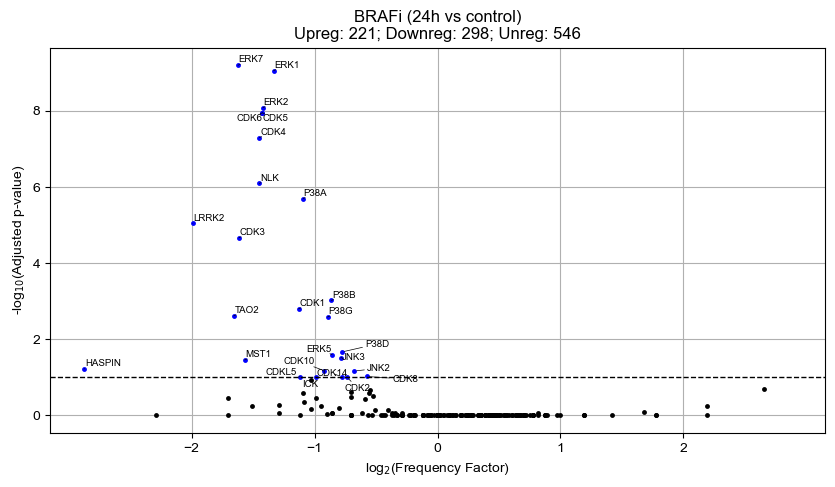

In [33]:
braf_inh_24h_enr_res.plot_volcano(title='BRAFi (24h vs control)')

As can be seen, the ERK kinases and the cell-cycle CDKs are the most inhibited kinases (i.e. they are enriched among downregulated phosphosites) upon BRAF inhibition for 24 hours.

The volcano plots can also be generated for upregulated and downregulated sites separately:

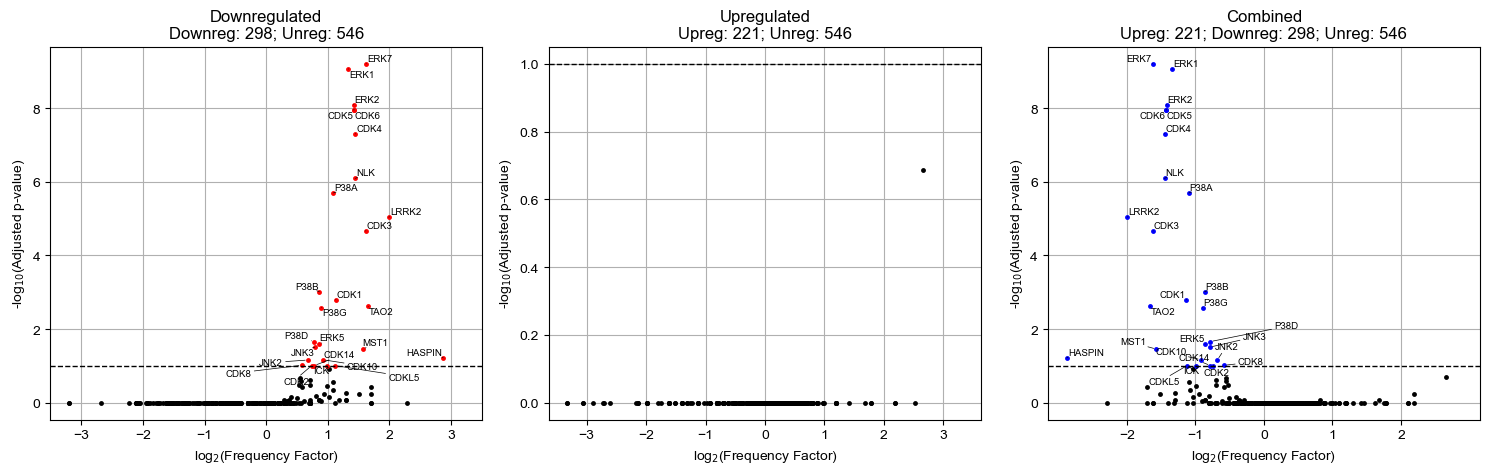

In [34]:
braf_inh_24h_enr_res.plot_down_up_comb_volcanos()


Calculating percentiles for upregulated sites (221 substrates)
Scoring 32 tyrosine substrates
Calculating percentile for 32 tyrosine substrates


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 2165.17it/s]


Calculating percentiles for downregulated sites (298 substrates)
Scoring 33 tyrosine substrates


Calculating percentile for 33 tyrosine substrates


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 2055.77it/s]


Calculating percentiles for background (unregulated) sites (546 substrates)
Scoring 114 tyrosine substrates


Calculating percentile for 114 tyrosine substrates


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 1924.74it/s]


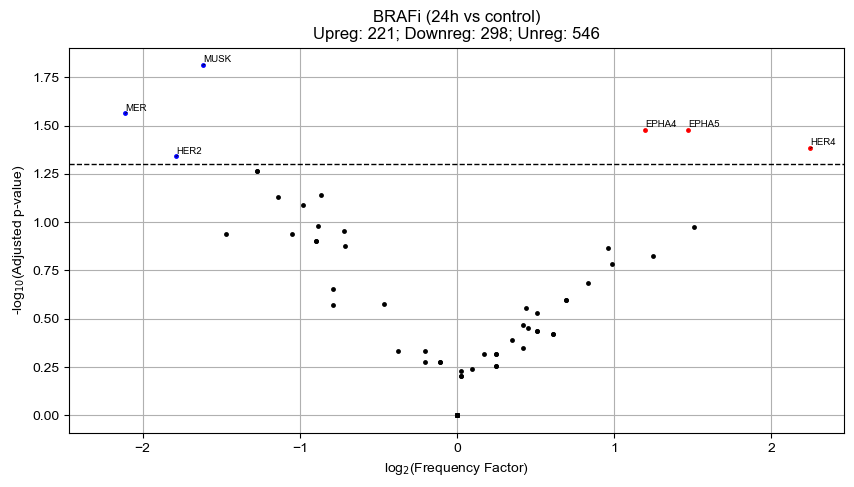

In [35]:
kin_type = 'tyrosine'
method = 'percentile_rank'
thresh = 8

braf_inh_24h_enr_res_tyr = braf_inh_24h_diff_phos.kinase_enrichment(kin_type=kin_type, kl_method=method, kl_thresh=thresh)

braf_inh_24h_enr_res_tyr.plot_volcano(title='BRAFi (24h vs control)', adj_pval=False, sig_pval=0.05)

### Plotting multiple comparisons

In case of multiple comparisons (e.g. multiple time points, drugs etc), results can be plotted together as a bubblemap:

_**Note: for further design options of the bubblemap please refer to the plotting data page_

In [36]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5] #For Jupyter Notebook

file_list = sorted([name for name in os.listdir('./test_files/BRAF_files/') if (name.startswith(".") == False)])
conds_name = ['15m+/0m', '45m+/0m', '90m+/0m', '6h+/0m', '12h+/0m', '24h+/0m', '72h+/0m', '72h+12h-/0m', '72h+24h-/0m', '72h+72h-/0m', '72h+6d-/0m', '72h+12h-/72h+', '72h+24h-/72h+', '72h+72h-/72h+', '72h+6d-/72h+', '24h+/24h', '72h+/72h']

# Scoring data one time at the beginning
phospho_data = pd.read_csv('./test_files/BRAF_files/'+file_list[0], sep='\t')
pps_data = kl.PhosphoProteomics(phospho_data, seq_col='Sequence')
ser_thr_percentiles = pps_data.percentile('ser_thr', values_only=True)

braf_inh_enrichment_results = {}

kin_type = 'ser_thr'
method = 'percentile_rank'
thresh = 15

for i,cond_file in enumerate(file_list):
    cond = '_'.join(cond_file.split('_')[2:4])
    print(cond)
    
    phospho_data = pd.read_csv('./test_files/BRAF_files/'+cond_file, sep='\t')
    
    braf_inh = kl.DiffPhosData(phospho_data, lfc_col='logFC', pval_col='adj.P.Val', seq_col='Sequence', pval_thresh=0.1, suppress_warnings=True)
    braf_inh.submit_percentiles(kin_type=kin_type, percentiles=ser_thr_percentiles, suppress_messages=True)
    
    braf_inh_enr_res = braf_inh.kinase_enrichment(kin_type=kin_type, kl_method=method, kl_thresh=thresh)
    
    braf_inh_enrichment_results[conds_name[i]] = braf_inh_enr_res

208 entries were omitted due to empty value in the substrates column.
Use the 'omited_entries' attribute to view dropped enteries due to invalid sequences.
Scoring 886 ser_thr substrates
Calculating percentile for 886 ser_thr substrates


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:02<00:00, 122.64it/s]


X15mP_X0m
X45mP_X0m
X90mP_X0m
X6hP_X0m
X12hP_X0m
X24hP_X0m
X72hP_X0m
X72hP12hM_X0m
X72hP24hM_X0m
X72hP72hM_X0m
X72hP6dM_X0m
X72hP12hM_X72hP
X72hP24hM_X72hP
X72hP72hM_X72hP
X72hP6dM_X72hP
X24hP_X24hM
X72hP_X72hM


/Users/tomer/opt/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/tomer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


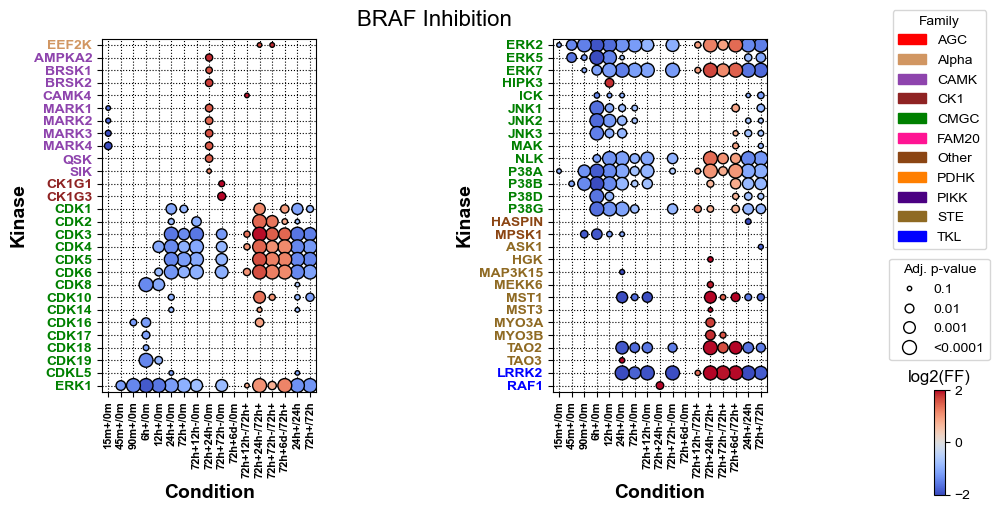

In [37]:
lff_data,pval_data,cont_kins_data = kl.combine_diff_phos_enrichment_results(braf_inh_enrichment_results, enrichment_type='combined')
kl.plot_bubblemap(lff_data=lff_data, pval_data=pval_data, cont_kins=cont_kins_data, title='BRAF Inhibition', max_window=False, only_sig_kins=True, num_panels=2)

/Users/tomer/opt/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/tomer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


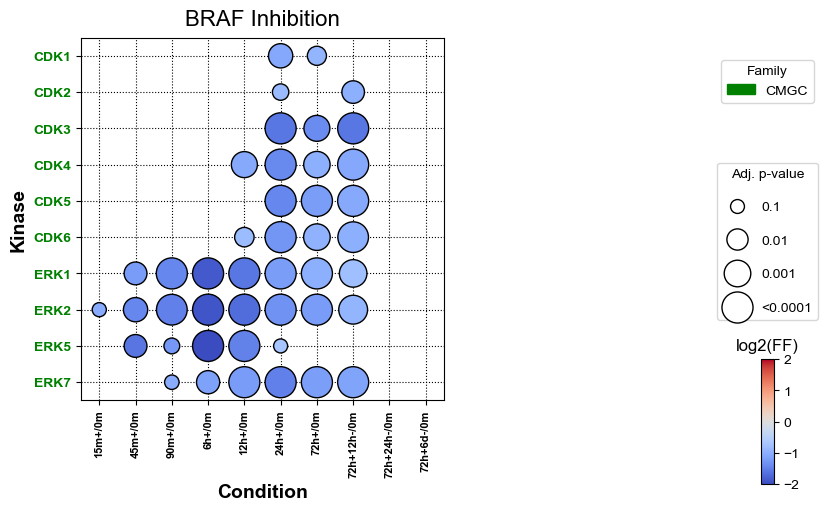

In [38]:
plot_kins = ['ERK1', 'ERK2', 'ERK5', 'ERK7', 'CDK1', 'CDK2', 'CDK3', 'CDK4', 'CDK5', 'CDK6']
conds = ['15m+/0m', '45m+/0m', '90m+/0m', '6h+/0m', '12h+/0m', '24h+/0m', '72h+/0m', '72h+12h-/0m', '72h+24h-/0m', '72h+6d-/0m']

kl.plot_bubblemap(lff_data=lff_data, pval_data=pval_data, cont_kins=cont_kins_data, only_sig_kins=True, num_panels=1, bubblesize_range=(100,500), pval_legend_spacing=1.5, title='BRAF Inhibition', kinases=plot_kins, cond_order=conds, max_window=False)

As expected, we can see an immediate inhibiton of the ERK kinases upon BRAF inhibition, that increases with time and deacreses upon lifting the inhibitor. Delayed inhibition of the cell-cycle related CDKs after 24 hours of BRAF inhibition can also be seen.

### Downstream Substrates

Finally, analysis of the activated and inhibited kinases can be used to derive a list of putative downstream substrates, most of which were never reported or even studied. For example, to explore downstream substrates of the ERK kinases:

_**Note: use the `save_to_excel` flag to directly save the results_

In [43]:
braf_inh_24h_enr_res.get_inhibited_kins()

['CDK1',
 'CDK2',
 'CDK3',
 'CDK4',
 'CDK5',
 'CDK6',
 'CDK8',
 'CDK10',
 'CDK14',
 'CDKL5',
 'ERK1',
 'ERK2',
 'ERK5',
 'ERK7',
 'HASPIN',
 'ICK',
 'JNK2',
 'JNK3',
 'LRRK2',
 'MST1',
 'NLK',
 'P38A',
 'P38B',
 'P38D',
 'P38G',
 'TAO2']

In [45]:
braf_inh_24h_enr_res.enriched_subs(kinases='ERK2', activity_type='inhibited', as_dataframe=True)

,Phosphosites,ORIGINAL_Sequence,logFC,AveExpr,t,P.Value,adj.P.Val,B,phos_res,Sequence,ERK2
Sequence,,,,,,,,,,,
KELESPLtPGKVCRA,ZNF609-pT746,KELESPLTPGKVCRA,-0.215351,0.017220,-2.066587,4.625009e-02,9.315881e-02,-5.143913,t,KELESPLtPGKVCRA,1
SFTEVPRsPKHAHSS,SVIL-pS245,SFTEVPRSPKHAHSS,-0.599486,-0.002125,-7.052897,3.303338e-08,4.247625e-07,8.564325,s,SFTEVPRsPKHAHSS,1
QPLTVPVsPKFSTRF,TPX2-pS738,QPLTVPVSPKFSTRF,-1.328573,-0.279630,-7.520899,8.340954e-09,1.193038e-07,9.937169,s,QPLTVPVsPKFSTRF,1
SGTSSPQsPVFRHRT,AFAP1-pS668,SGTSSPQSPVFRHRT,-1.117210,-0.303981,-7.674393,5.336480e-09,8.003078e-08,10.382927,s,SGTSSPQsPVFRHRT,1
MPQELPQsPRTRQPE,MINDY1-pS103,MPQELPQSPRTRQPE,-0.421470,0.082392,-3.662599,8.199872e-04,2.961728e-03,-1.402906,s,MPQELPQsPRTRQPE,1
...,...,...,...,...,...,...,...,...,...,...,...
AGKGTPLtPPACACS,NEK9-pT886,AGKGTPLTPPACACS,-0.330689,0.065408,-4.439772,8.628869e-05,4.068352e-04,0.779160,t,AGKGTPLtPPACACS,14
ADTTSPEtPDSSASK,DCTN1-pT108,ADTTSPETPDSSASK,-0.256562,0.003707,-3.231039,2.689500e-03,8.391504e-03,-2.535610,t,ADTTSPEtPDSSASK,15
DAEEEIGtPRKFTRD,RBL1-pT332,DAEEEIGTPRKFTRD,-2.050843,-0.393446,-10.608538,1.813163e-12,8.965504e-11,18.358378,t,DAEEEIGtPRKFTRD,15


In [50]:
braf_inh_24h_enr_res.enriched_subs(kinases=['ERK1','ERK2','ERK5','ERK7'], activity_type='inhibited')

{'ERK1':                   Phosphosites ORIGINAL_Sequence     logFC   AveExpr  \
 Sequence                                                               
 RVDLEPVsPRSCLTK  NCKAP5L-pS767   RVDLEPVSPRSCLTK -1.259993  0.124946   
 GGDEPPTsPRQLQPA    IRS2-pS1203   GGDEPPTSPRQLQPA -0.686676 -0.051711   
 VVPQVPTsPKSSLSV   RAPH1-pS1154   VVPQVPTSPKSSLSV -0.644816  0.095178   
 FFQPPPLtPTSKVYT      OGA-pT709   FFQPPPLTPTSKVYT -1.592363 -0.035858   
 LGSETPSsPRAGQLL       ACD-pS25   LGSETPSSPRAGQLL -0.187148 -0.061109   
 ...                        ...               ...       ...       ...   
 EAAAVPTtPRRGRPP    SPEN-pT1947   EAAAVPTTPRRGRPP -0.797116 -0.124815   
 EETREPGsPPSVQRA    CCDC86-pS47   EETREPGSPPSVQRA -0.247638 -0.051797   
 RVKALPLsPRKRLGD      CDC6-pS54   RVKALPLSPRKRLGD -5.142919 -0.850297   
 LCQHKPLtPQGDELS   USP32-pT1326   LCQHKPLTPQGDELS -1.065413 -0.166777   
 SRRNEPEsPRHRPKD    DHX38-pS199   SRRNEPESPRHRPKD -0.623636 -0.004653   
 
                         t       P.Value 